In [55]:
# Importing Libraries
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandarallel
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import keras
import tensorflow as tf
from kerastuner.engine.hyperparameters import HyperParameters
from keras.activations import relu
from keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from kerastuner.tuners import RandomSearch, Sklearn
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import math
import os

In [5]:
filename = "./Final_EDA.csv"

In [6]:
df = pd.read_csv(filename)

In [7]:
# Sorting DataFrame by our index before setting it as such
# df.sort_values(by=["host_since"], inplace=True, ascending=True)   # host_since is the closest thing to a date or date_time column we have
# df.set_index("host_since", inplace=True)

In [8]:
df.head()

,Unnamed: 0,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_identity_verified,host_since,instant_bookable,review_scores_rating,zipcode,bedrooms,beds,price
0,54511,0,0,8,2,4,2,1,0,1,16115,1,100,2108,4,4,259.0
1,20313,0,0,4,1,4,2,1,0,0,15786,1,89,2108,1,2,89.0
2,68172,0,0,2,1,4,0,1,0,0,16347,1,87,2108,1,1,225.0
3,62506,0,0,3,1,4,2,1,0,1,15554,1,87,2108,1,1,185.0
4,56709,0,0,2,1,4,1,0,0,1,16279,0,91,2108,1,1,199.0


In [9]:
df.drop(columns="Unnamed: 0", inplace=True)

In [10]:
df.shape

(38499, 16)

In [11]:
df.dtypes

property_type               int64
room_type                   int64
accommodates                int64
bathrooms                   int64
bed_type                    int64
cancellation_policy         int64
cleaning_fee                int64
city                        int64
host_identity_verified      int64
host_since                  int64
instant_bookable            int64
review_scores_rating        int64
zipcode                     int64
bedrooms                    int64
beds                        int64
price                     float64
dtype: object

In [12]:
# Splitting data into target and feature matrix
target = 'price'
X = df.drop(columns=target)
y = df[target]

In [13]:
# Sanity Check
assert len(X) == len(y)

In [14]:
X.dtypes

property_type             int64
room_type                 int64
accommodates              int64
bathrooms                 int64
bed_type                  int64
cancellation_policy       int64
cleaning_fee              int64
city                      int64
host_identity_verified    int64
host_since                int64
instant_bookable          int64
review_scores_rating      int64
zipcode                   int64
bedrooms                  int64
beds                      int64
dtype: object

In [15]:
print(X)

       property_type  room_type  accommodates  bathrooms  bed_type  \
0                  0          0             8          2         4   
1                  0          0             4          1         4   
2                  0          0             2          1         4   
3                  0          0             3          1         4   
4                  0          0             2          1         4   
...              ...        ...           ...        ...       ...   
38494              0          1             2          1         4   
38495              0          1             3          1         4   
38496              0          0             2          1         4   
38497              0          1             1          1         4   
38498              0          1             4          1         4   

       cancellation_policy  cleaning_fee  city  host_identity_verified  \
0                        2             1     0                       1   
1          

In [16]:
# Standardizating data
# X_scaled = StandardScaler().fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [18]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.38, random_state=42)

In [19]:
# Sanity Checks
len(X_train) == len(y_train)
len(X_val) == len(y_val)
len(X_test) == len(y_test)

True

In [20]:
print("Number of Rows for Training Set: ", len(X_train))
print("Number of Rows for Validation Set: ", len(X_val))
print("Number of Rows for Testing Set: ", len(X_test))
# The validation set is smaller than the testing set. This is why I have the second train_test_split in
# an odd arrangement, had to make sure val was smaller than test

Number of Rows for Training Set:  23099
Number of Rows for Validation Set:  5852
Number of Rows for Testing Set:  9548


In [21]:
# Regression Baseline
y_pred = [y_train.mean()] * len(y_train)

baseline_mae = mean_absolute_error(y_train, y_pred)
print('Baseline MAE:', baseline_mae)

Baseline MAE: 79.97292301694209


## Building Our Model

In [49]:
# get dim of image row vectors and save to imput_dim
imput_dim = X_train.shape[1]

In [23]:
def build_regression_model(hp):
    
    """
    Returns a complied keras model ready for keras-tuner gridsearch algorithms 
    """
    
    model = Sequential()
    
    # 1st hidden layer
    model.add(Dense(input_dim=imput_dim,
                    units=hp.get('units'),
                    activation=hp.get("activation")))
    
    # 2nd hidden layer 
    model.add(Dense(units=hp.get('units'),
                    activation=hp.get("activation")))
    
    # 3rd hidden layer 
    model.add(Dense(units=hp.get('units'),
                    activation=hp.get("activation")))
    
    # output layer
    model.add(Dense(1, activation='relu'))
    
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(hp.get('learning_rate')),
        loss='mse',
        metrics=['mae'])
    
    return model

In [24]:
# build out our hyperparameter dictionary 
hp = HyperParameters()
hp.Int('units', min_value=32, max_value=512, step=32)
hp.Choice('learning_rate',values=[1e-1, 1e-2, 1e-3])
hp.Choice('activation',values=["linear", "relu"])

'linear'

In [25]:
n_unique_hparam_combos = len(range(32,512+32, 32)) * 3 *2
n_param_combos_to_sample = n_unique_hparam_combos * .25

In [26]:
random_tuner = RandomSearch(
            build_regression_model,
            objective='val_mae',
            max_trials=n_param_combos_to_sample, # number of times to sample the parameter set and build a model 
            seed=1234,
            hyperparameters=hp, # pass in our hyperparameter dictionary
            directory='./keras-tuner-trial',
            project_name='random_search')

In [27]:
# take note of Total elapsed time in print out
random_tuner.search(X_train,
                    y_train,
                    epochs=10,
                    validation_data=(X_val, y_val))

Trial 24 Complete [00h 00m 16s]
val_mae: 146.27255249023438

Best val_mae So Far: 146.27255249023438
Total elapsed time: 00h 07m 49s
INFO:tensorflow:Oracle triggered exit


In [28]:
# identify the best score and hyperparamter (should be at the top since scores are ranked)
random_tuner.results_summary()

Results summary
Results in ./keras-tuner-trial/random_search
Showing 10 best trials
Objective(name='val_mae', direction='min')
Trial summary
Hyperparameters:
units: 480
learning_rate: 0.001
activation: relu
Score: 146.27255249023438
Trial summary
Hyperparameters:
units: 96
learning_rate: 0.1
activation: linear
Score: 146.27255249023438
Trial summary
Hyperparameters:
units: 352
learning_rate: 0.001
activation: linear
Score: 146.27255249023438
Trial summary
Hyperparameters:
units: 384
learning_rate: 0.01
activation: linear
Score: 146.27255249023438
Trial summary
Hyperparameters:
units: 288
learning_rate: 0.1
activation: linear
Score: 146.27255249023438
Trial summary
Hyperparameters:
units: 416
learning_rate: 0.001
activation: relu
Score: 146.27255249023438
Trial summary
Hyperparameters:
units: 224
learning_rate: 0.001
activation: relu
Score: 146.27255249023438
Trial summary
Hyperparameters:
units: 96
learning_rate: 0.01
activation: linear
Score: 146.27255249023438
Trial summary
Hyperpara

# Trial summary


## Hyperparameters:

*units:* **480**

*learning_rate:* **0.001**

*activation:* **relu**

---
*Score:* **146.27255249023438**

In [56]:
## Building model created from inspiration from another classmate

# Instantiating Model
model = Sequential()

# First Hidden Layer
model.add(Dense(1024, input_dim = imput_dim))    # Input layer
model.add(LeakyReLU(alpha=0.05))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(LeakyReLU(alpha=0.05))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(LeakyReLU(alpha=0.05))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(256,))
model.add(LeakyReLU(alpha=0.05))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(256))
model.add(LeakyReLU(alpha=0.05))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))

# Output layer
model.add(Dense(1, activation="linear"))

model.compile(optimizer=Adam(lr=0.005, decay=5e-4), loss='mse')

In [69]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 1024)              16384     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)              

In [63]:
## Model created from inspiration from another classmate

history = model.fit(X_train,
                    y_train.values,
                    validation_data=(X_val,y_val.values),
                    batch_size=128,
                    epochs=150)

model.save('leaky_relu_model')

Epoch 1/150
181/181 [==============================] - 3s 18ms/step - loss: 8797.5283 - val_loss: 8250.2393
Epoch 2/150
181/181 [==============================] - 3s 17ms/step - loss: 8686.6787 - val_loss: 8444.6846
Epoch 3/150
181/181 [==============================] - 3s 17ms/step - loss: 8718.5332 - val_loss: 8507.5957
Epoch 4/150
181/181 [==============================] - 3s 17ms/step - loss: 8719.3984 - val_loss: 9484.0166
Epoch 5/150
181/181 [==============================] - 3s 17ms/step - loss: 8751.0625 - val_loss: 8211.4541
Epoch 6/150
181/181 [==============================] - 3s 17ms/step - loss: 8737.4600 - val_loss: 8436.1846
Epoch 7/150
181/181 [==============================] - 3s 16ms/step - loss: 8786.9609 - val_loss: 8647.6699
Epoch 8/150
181/181 [==============================] - 3s 17ms/step - loss: 8735.1865 - val_loss: 8160.0884
Epoch 9/150
181/181 [==============================] - 3s 17ms/step - loss: 8716.2090 - val_loss: 8500.2119
Epoch 10/150
181/181 [======

<AxesSubplot:>

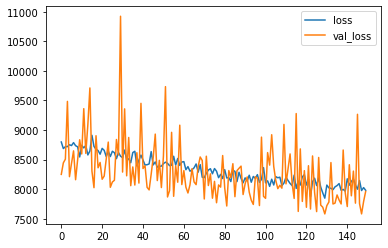

In [64]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [65]:
# Saving output of our model's predictions
predictions = model.predict(X_test)

In [66]:
# Our Mean Absolute Error
mean_absolute_error(y_test, predictions)

51.27827306706685

In [68]:
# Evaluating model's predictive power
predictions = model.predict(X_test, batch_size=32)
predictions

array([[186.94229],
       [198.92773],
       [ 68.80703],
       ...,
       [110.6443 ],
       [ 78.9217 ],
       [135.75525]], dtype=float32)

In [67]:
# Actual prices
y_test

3494      99.0
24311    110.0
12761     50.0
9375     112.0
1465     119.0
         ...  
12135    140.0
13468    130.0
32132     89.0
20233     70.0
14657    140.0
Name: price, Length: 9548, dtype: float64

## MY RANDOM SEARCH

In [50]:
## Plugging in best params

# Instantiating our model's class architecture
model = Sequential()
    
# hidden layer
model.add(Dense(140,
                input_dim=imput_dim,
                activation='relu'))

model.add(Dense(280,
                activation='relu'))
    
# output layer
model.add(Dense(1,
                activation='relu'))

# Assigning learning rate to RMSprop optimizer
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)

# compiling our model architecture with loss function & corresponding metric
model.compile(optimizer=opt,
              loss='mse',
              metrics=['mae'])

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 140)               2240      
_________________________________________________________________
dense_10 (Dense)             (None, 280)               39480     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 281       
Total params: 42,001
Trainable params: 42,001
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Use TensorBoard if you're running this on Colab

# %load_ext tensorboard

# import os
# import datetime

# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [32]:
# Readying our EarlyStop callback
stop_callback = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, mode="min")

In [44]:
# Fitting model
model.fit(X_train,
          y_train,
          batch_size=42,
          epochs=20,
          validation_data=(X_val, y_val))

# Save the entire model as a Saved Model.
model.save('retrained_rs_model')

Epoch 1/20
550/550 [==============================] - 1s 2ms/step - loss: 38802.6836 - mae: 146.0290 - val_loss: 38405.5352 - val_mae: 146.2726
Epoch 2/20
550/550 [==============================] - 1s 2ms/step - loss: 38802.6602 - mae: 146.0290 - val_loss: 38405.5352 - val_mae: 146.2726
Epoch 3/20
550/550 [==============================] - 1s 2ms/step - loss: 38802.6797 - mae: 146.0290 - val_loss: 38405.5352 - val_mae: 146.2726
Epoch 4/20
550/550 [==============================] - 1s 2ms/step - loss: 38802.6562 - mae: 146.0290 - val_loss: 38405.5352 - val_mae: 146.2726
Epoch 5/20
550/550 [==============================] - 1s 2ms/step - loss: 38802.6758 - mae: 146.0290 - val_loss: 38405.5352 - val_mae: 146.2726
Epoch 6/20
550/550 [==============================] - 1s 2ms/step - loss: 38802.6562 - mae: 146.0290 - val_loss: 38405.5352 - val_mae: 146.2726
Epoch 7/20
550/550 [==============================] - 1s 2ms/step - loss: 38802.6289 - mae: 146.0290 - val_loss: 38405.5352 - val_mae: 1

In [34]:
new_model = tf.keras.models.load_model('retrained_rs_model')

In [35]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 140)               2240      
_________________________________________________________________
dense_5 (Dense)              (None, 240)               33840     
_________________________________________________________________
dense_6 (Dense)              (None, 480)               115680    
_________________________________________________________________
dense_7 (Dense)              (None, 240)               115440    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 241       
Total params: 267,441
Trainable params: 267,441
Non-trainable params: 0
_________________________________________________________________


In [36]:
# %load_ext tensorboard
# %tensorboard --logdir logs

In [61]:
# Evaluating model's predictive power
predictions = model.predict(X_test, batch_size=32)
predictions

array([[176.80292],
       [175.44208],
       [ 70.69791],
       ...,
       [121.52776],
       [ 79.25338],
       [117.11068]], dtype=float32)

In [62]:
# Actual prices
y_test

3494      99.0
24311    110.0
12761     50.0
9375     112.0
1465     119.0
         ...  
12135    140.0
13468    130.0
32132     89.0
20233     70.0
14657    140.0
Name: price, Length: 9548, dtype: float64